In [1]:
import os
import warnings
from functools import partialmethod

import healpy as hp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from tools.chi2_functions import (get_fiducial_gaussian_chi2, get_hl_chi2,
                                  get_ideal_ptep_chi2, get_lollipop_chi2,
                                  get_offset_hl_chi2)
from tools.common_functions import (compute_offsets,
                                    compute_theoretical_spectrum)

In [2]:
tqdm.__init__ = partialmethod(tqdm.__init__, colour="green", ncols=120)
warnings.filterwarnings("ignore")

plt.rc("axes", labelsize=20, linewidth=1.5)
plt.rc("xtick", direction="in", labelsize=15, top=True)
plt.rc("ytick", direction="in", labelsize=15, right=True)

plt.rc("xtick.major", width=1.1, size=5)
plt.rc("ytick.major", width=1.1, size=5)

plt.rc("xtick.minor", width=1.1, size=3)
plt.rc("ytick.minor", width=1.1, size=3)

plt.rc("lines", linewidth=2)
plt.rc("legend", frameon=False, fontsize=15)
plt.rc("figure", dpi=100, autolayout=True, figsize=[10, 7])
plt.rc("savefig", dpi=150, bbox="tight")

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["red", "dodgerblue", "forestgreen", "goldenrod", "maroon", "cyan", "limegreen", "darkorange", "darkmagenta"])

## Setting up relevant quantities

In [3]:
N_sims = 1000

fsky = 40
nside = 16
npix = hp.nside2npix(nside)

fwhm = 1.33333 # beam in [deg] (this corresponds to 80 arcmin beam)
spec = ["EE", "BB"]

lmax = 30
ell = np.arange(2, lmax + 1)
ell_full = np.arange(2, 501)
ell_factor = ell * (ell + 1) / (2 * np.pi)

# Grid of r values
r005s = np.linspace(-0.01, 0.02, 1201)

want_systematic = False
prefix = ""
if want_systematic:
    prefix = "sys_"

mitigate_systematic = True and want_systematic

In [4]:
CURRENT_PATH = os.path.abspath("")

chi2s_folder = CURRENT_PATH + "/chi2s/"
spectra_folder = CURRENT_PATH + "/spectra/"

print(CURRENT_PATH)

/home/ggalloni/Projects/LB_handson_2024


In [5]:
############################### COMPUTE LENSING SPECTRUM ###############################

fiducial_spectrum = compute_theoretical_spectrum(lmax, r=0.0)
print("Fiducial spectrum computed")
print(fiducial_spectrum.shape)

Fiducial spectrum computed
(31, 4)


In [6]:
noise_level = 10.0  # muK-arcmin

pixarea = hp.nside2pixarea(nside, degrees=True)
varperpix = (noise_level / 60.)**2 / pixarea

nl = varperpix * 4. * np.pi / (12*nside**2.)

noise_spectrum = np.ones_like(ell) * nl

systematic_level = 20.0  # muK-arcmin

pixarea = hp.nside2pixarea(nside, degrees=True)
sys_varperpix = (systematic_level / 60.)**2 / pixarea

sys_nl = sys_varperpix * 4. * np.pi / (12*nside**2.)

systematic_spectrum = sys_nl / ell_factor

Templates are the theoretical spectra on the grid values of r. Computing them takes
more or less 6/7 minutes on my laptop so I precomputed them...

In [7]:
file = spectra_folder + "templates_rm0p01_to_r0p02.npy"
templates = np.load(file)[:, :lmax - 1]
templates /= ell_factor[None, :]

print(templates.shape)

(1201, 29)


In [8]:
filename = f"{prefix}cutsky_spectra_{fsky}fsky_80arcminbeam_1000sims.npy"
cutsky_spectra = np.load(spectra_folder + filename)

## Computing the $\chi^2$

In [9]:
covariance = np.cov(np.array(cutsky_spectra[: int(N_sims / 2 + 1), 1]).T)
inv_covariance = np.linalg.inv(covariance)

print(covariance.shape)

(29, 29)


In [10]:
offset = compute_offsets(
    ell,
    np.diag(covariance),
    fiducial_spectrum[2:, 2] + noise_spectrum + systematic_spectrum if mitigate_systematic else fiducial_spectrum[2:, 2] + noise_spectrum,
    fsky=fsky/100,
    iter=30,
)

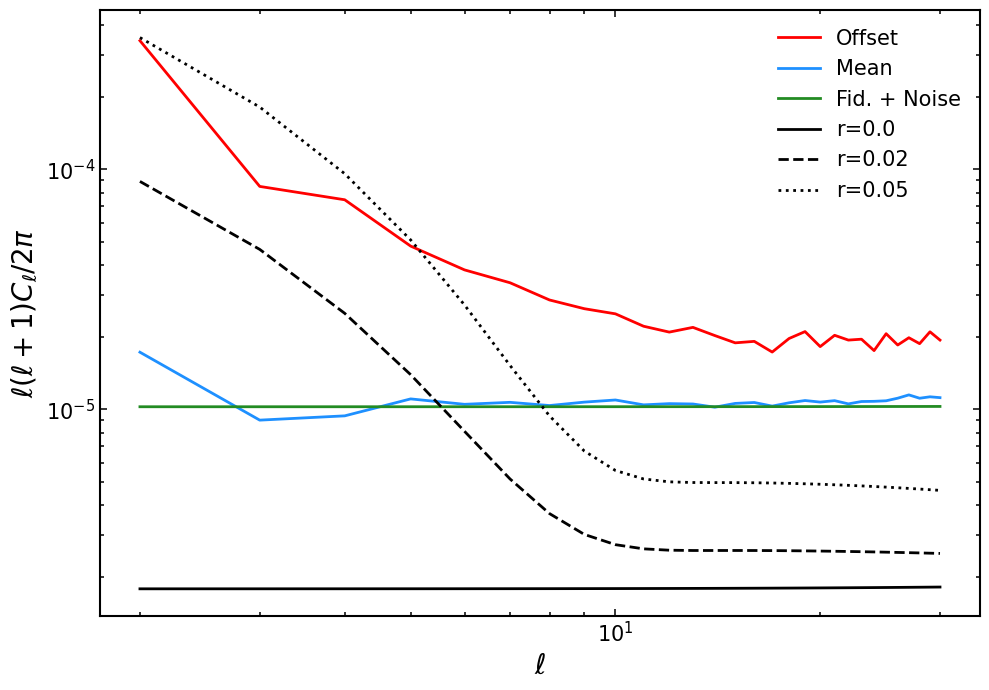

In [11]:
plt.plot(ell, offset, label="Offset")

plt.plot(ell, np.mean(cutsky_spectra[:, 1], axis=0), label="Mean")
plt.plot(ell, (fiducial_spectrum[2:, 2] + noise_spectrum), label="Fid. + Noise")

if want_systematic:
    plt.plot(ell, (fiducial_spectrum[2:, 2] + noise_spectrum + systematic_spectrum), label="Fid. + Noise + Sys.")

plt.plot(ell, templates[400], label="r=0.0", color = "black", ls="-")
plt.plot(ell, templates[600], label="r=0.02", color = "black", ls="--")
plt.plot(ell, templates[-1], label="r=0.05", color = "black", ls=":")

plt.loglog()

plt.legend(loc = "upper right")

plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell(\ell+1)C_{\ell}/2\pi$")

plt.show()

In [12]:
fiducial_gaussian = np.zeros((len(r005s), int(N_sims / 2)))
ideal_ptep = np.zeros((len(r005s), int(N_sims / 2)))
ideal_ptep_fsky_squared = np.zeros((len(r005s), int(N_sims / 2)))
hl_likelihood = np.zeros((len(r005s), int(N_sims / 2)))
ohl_likelihood = np.zeros((len(r005s), int(N_sims / 2)))
lollipop_no_offset = np.zeros((len(r005s), int(N_sims / 2)))
lollipop = np.zeros((len(r005s), int(N_sims / 2)))

<h2 style="text-align: center;">Fiducial Gaussian</h2>

\begin{gather*}

\chi^2 = \big(\hat{C}_\ell - C^{th}_\ell\big) \times (\text{COV}^{-1}_{\ell \ell^\prime})_{Fid.} \times \big(\hat{C}_{\ell^\prime} - C^{th}_{\ell^\prime}\big) \\

\text{where} \\ 
C^{th}_\ell = C_\ell^{Prim.} + C_\ell^{Lens.} + N_\ell


\end{gather*}

In [13]:
for r_idx in tqdm(range(len(r005s)), desc="Fiducial Gaussian".center(30)):
    fiducial_gaussian[r_idx] = get_fiducial_gaussian_chi2(
        data=cutsky_spectra[int(N_sims / 2):, 1],
        template=templates[r_idx],
        noise=noise_spectrum + systematic_spectrum if mitigate_systematic else noise_spectrum,
        inv_cov=inv_covariance,
    )
file = f"{prefix}fiducial_gaussian_{fsky}fsky_80arcminbeam_1000sims.npy"
np.save(chi2s_folder + file, fiducial_gaussian)
print("Fiducial Gaussian done")
print(fiducial_gaussian.shape)

      Fiducial Gaussian       : 100%|██████████████████████████████████████████████| 1201/1201 [00:01<00:00, 772.88it/s]


Fiducial Gaussian done
(1201, 500)


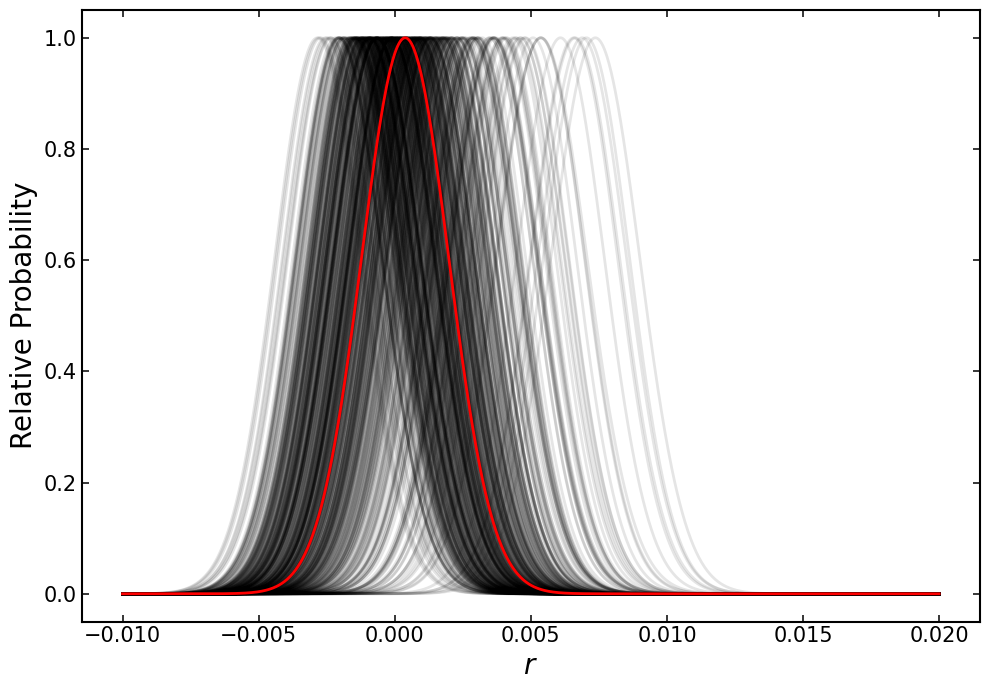

In [14]:
plt.figure()
for i in range(N_sims // 2):
    plt.plot(r005s, np.exp(-0.5*fiducial_gaussian[:, i])/np.max(np.exp(-0.5*fiducial_gaussian[:, i])), color= "black", alpha = 0.1)

plt.plot(r005s, np.exp(-0.5*np.mean(fiducial_gaussian, axis=1))/np.max(np.exp(-0.5*np.mean(fiducial_gaussian, axis=1))))

plt.xlabel(r"$r$")
plt.ylabel("Relative Probability")
plt.show()

<h2 style="text-align: center;">Ideal PTEP-like</h2>

\begin{gather*}

\chi^2 = \sum_\ell (2\ell + 1) f_{sky} \Big(\frac{\hat{C}_\ell}{C^{th}_\ell} - \log\frac{\hat{C}_\ell}{C^{th}_\ell} - 1\Big)  \\

\text{where} \\ 
C^{th}_\ell = C_\ell^{Prim.} + C_\ell^{Lens.} + N_\ell


\end{gather*}

In [15]:
for r_idx in tqdm(range(len(r005s)), desc="Ideal PTEP".center(30)):
    ideal_ptep[r_idx] = get_ideal_ptep_chi2(
        data=cutsky_spectra[int(N_sims / 2):, 1],
        template=templates[r_idx],
        noise=noise_spectrum + systematic_spectrum if mitigate_systematic else noise_spectrum,
        fsky=fsky / 100,
        ell=ell,
    )
file = f"{prefix}ideal_ptep_{fsky}fsky_80arcminbeam_1000sims.npy"
np.save(chi2s_folder + file, ideal_ptep)
print("Ideal PTEP done")
print(ideal_ptep.shape)

          Ideal PTEP          : 100%|█████████████████████████████████████████████| 1201/1201 [00:00<00:00, 5548.09it/s]

Ideal PTEP done
(1201, 500)


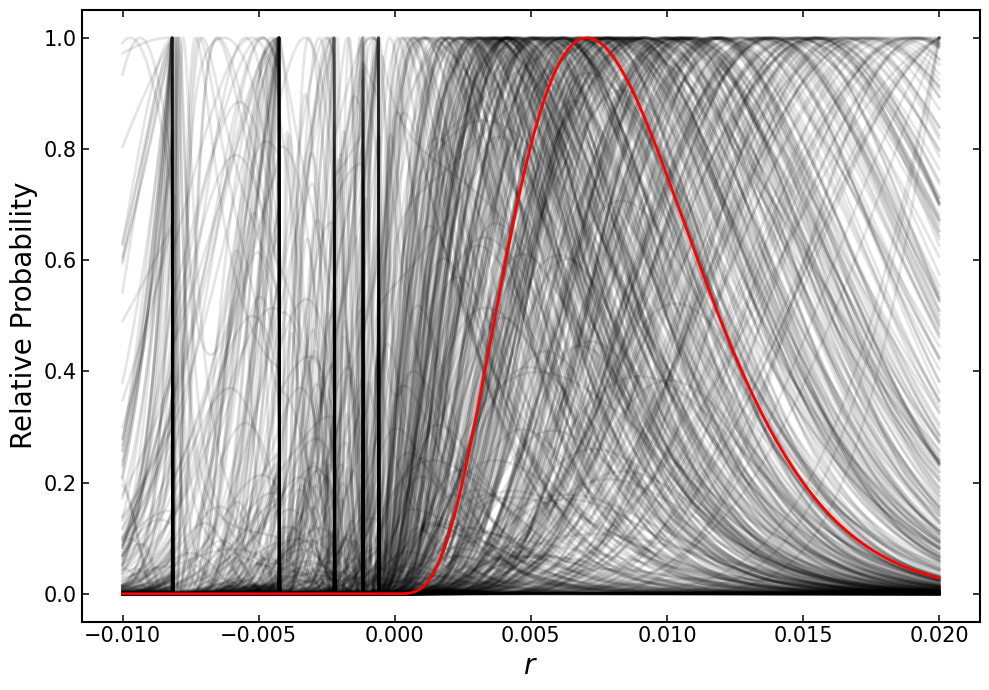

In [16]:
plt.figure()
for i in range(N_sims // 2):
    plt.plot(r005s, np.exp(-0.5*ideal_ptep[:, i])/np.max(np.exp(-0.5*ideal_ptep[:, i])), color= "black", alpha = 0.1)

plt.plot(r005s, np.exp(-0.5*np.mean(ideal_ptep, axis=1))/np.max(np.exp(-0.5*np.mean(ideal_ptep, axis=1))))

plt.xlabel(r"$r$")
plt.ylabel("Relative Probability")
plt.show()

<h2 style="text-align: center;">Ideal PTEP-like with fsky squared</h2>

\begin{gather*}

\chi^2 = \sum_\ell (2\ell + 1) f_{sky}^2 \Big(\frac{\hat{C}_\ell}{C^{th}_\ell} - \log\frac{\hat{C}_\ell}{C^{th}_\ell} - 1\Big)  \\

\text{where} \\ 
C^{th}_\ell = C_\ell^{Prim.} + C_\ell^{Lens.} + N_\ell


\end{gather*}

In [17]:
for r_idx in tqdm(range(len(r005s)), desc="Ideal PTEP with f_{sky}^2".center(30)):
    ideal_ptep_fsky_squared[r_idx] = get_ideal_ptep_chi2(
        data=cutsky_spectra[int(N_sims / 2):, 1],
        template=templates[r_idx],
        noise=noise_spectrum + systematic_spectrum if mitigate_systematic else noise_spectrum,
        fsky=(fsky / 100)**2,
        ell=ell,
    )
file = f"{prefix}ideal_ptep_fsky_squared_{fsky}fsky_80arcminbeam_1000sims.npy"
np.save(chi2s_folder + file, ideal_ptep_fsky_squared)
print(r"Ideal PTEP with f_{sky}^2 done")
print(ideal_ptep_fsky_squared.shape)

  Ideal PTEP with f_{sky}^2   : 100%|█████████████████████████████████████████████| 1201/1201 [00:00<00:00, 6194.12it/s]

Ideal PTEP with f_{sky}^2 done
(1201, 500)


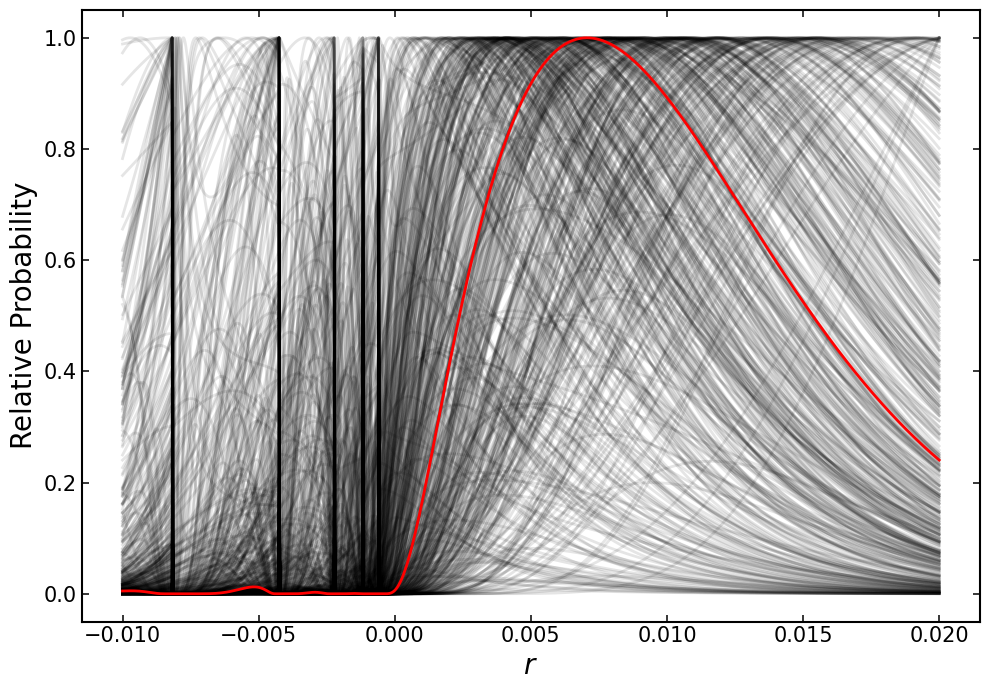

In [18]:
plt.figure()
for i in range(N_sims // 2):
    plt.plot(r005s, np.exp(-0.5*ideal_ptep_fsky_squared[:, i])/np.max(np.exp(-0.5*ideal_ptep_fsky_squared[:, i])), color= "black", alpha = 0.1)

plt.plot(r005s, np.exp(-0.5*np.mean(ideal_ptep_fsky_squared, axis=1))/np.max(np.exp(-0.5*np.mean(ideal_ptep_fsky_squared, axis=1))))

plt.xlabel(r"$r$")
plt.ylabel("Relative Probability")
plt.show()

<h2 style="text-align: center;">Hamimeche & Lewis Likelihood</h2>

\begin{gather*}

\chi^2 = \Big[C^{Fid}_\ell g\Big( \frac{\hat{C}_\ell}{C^{th}_\ell} \Big)\Big] \times (\text{COV}^{-1}_{\ell \ell^\prime})_{Fid.} \times \Big[C^{Fid}_\ell g\Big( \frac{\hat{C}_\ell}{C^{th}_\ell} \Big)\Big]  \\

\text{where} \\ 
C^{th}_\ell = C_\ell^{Prim.} + C_\ell^{Lens.} + N_\ell \\
C^{Fid}_\ell = C_\ell^{Lens.} + N_\ell \\
g(x) = \text{sign}(x - 1)\sqrt{2(x-\log x -1)}


\end{gather*}

In [19]:
for r_idx in tqdm(range(len(r005s)), desc="HL".center(30)):
    hl_likelihood[r_idx] = get_hl_chi2(
        data=cutsky_spectra[int(N_sims / 2):, 1],
        template=templates[r_idx],
        fiducial=fiducial_spectrum[2:, 2],
        noise=noise_spectrum + systematic_spectrum if mitigate_systematic else noise_spectrum,
        inv_cov=inv_covariance,
    )
file = f"{prefix}hl_{fsky}fsky_80arcminbeam_1000sims.npy"
np.save(chi2s_folder + file, hl_likelihood)
print("HL done")
print(hl_likelihood.shape)

              HL              : 100%|█████████████████████████████████████████████| 1201/1201 [00:01<00:00, 1056.56it/s]

HL done
(1201, 500)


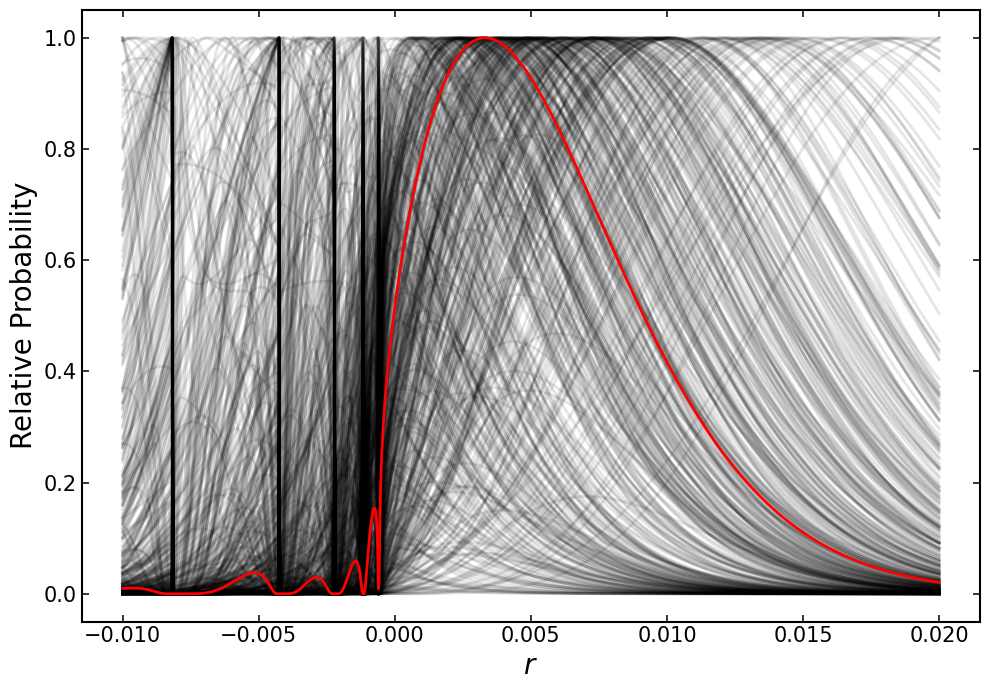

In [20]:
plt.figure()
for i in range(N_sims // 2):
    plt.plot(r005s, np.exp(-0.5*hl_likelihood[:, i])/np.max(np.exp(-0.5*hl_likelihood[:, i])), color= "black", alpha = 0.1)

plt.plot(r005s, np.exp(-0.5*np.mean(hl_likelihood, axis=1))/np.max(np.exp(-0.5*np.mean(hl_likelihood, axis=1))))

plt.xlabel(r"$r$")
plt.ylabel("Relative Probability")
plt.show()

<h2 style="text-align: center;">Offset Hamimeche & Lewis Likelihood</h2>

\begin{gather*}

\chi^2 = \Big[(C^{Fid}_\ell + O_\ell) g\Big( \frac{\hat{C}_\ell + O_\ell}{C^{th}_\ell + O_\ell} \Big)\Big] \times (\text{COV}^{-1}_{\ell \ell^\prime})_{Fid.} \times \Big[(C^{Fid}_\ell + O_\ell) g\Big( \frac{\hat{C}_\ell + O_\ell}{C^{th}_\ell + O_\ell} \Big)\Big]  \qquad \\

\text{where} \qquad \\ 
C^{th}_\ell = C_\ell^{Prim.} + C_\ell^{Lens.} + N_\ell \qquad \\
C^{Fid}_\ell = C_\ell^{Lens.} + N_\ell \qquad \\
g(x) = \text{sign}(x - 1)\sqrt{2(x-\log x -1)} \qquad


\end{gather*}

In [21]:
for r_idx in tqdm(range(len(r005s)), desc="Offset HL".center(30)):
    ohl_likelihood[r_idx] = get_offset_hl_chi2(
        data=cutsky_spectra[int(N_sims / 2):, 1],
        template=templates[r_idx],
        fiducial=fiducial_spectrum[2:, 2],
        noise=noise_spectrum + systematic_spectrum if mitigate_systematic else noise_spectrum,
        inv_cov=inv_covariance,
        offset=offset,
    )
file = f"{prefix}offset_hl_{fsky}fsky_80arcminbeam_1000sims.npy"
np.save(chi2s_folder + file, ohl_likelihood)
print("Offset HL done")
print(ohl_likelihood.shape)

          Offset HL           : 100%|██████████████████████████████████████████████| 1201/1201 [00:01<00:00, 877.57it/s]

Offset HL done
(1201, 500)


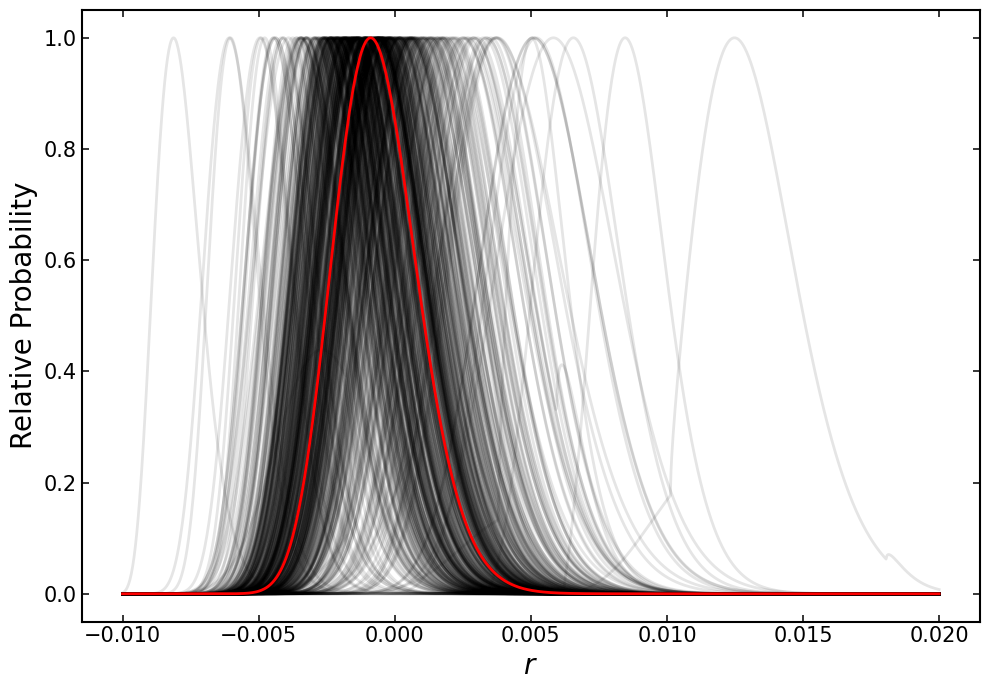

In [22]:
plt.figure()
for i in range(N_sims // 2):
    plt.plot(r005s, np.exp(-0.5*ohl_likelihood[:, i])/np.max(np.exp(-0.5*ohl_likelihood[:, i])), color= "black", alpha = 0.1)

plt.plot(r005s, np.exp(-0.5*np.mean(ohl_likelihood, axis=1))/np.max(np.exp(-0.5*np.mean(ohl_likelihood, axis=1))))

plt.xlabel(r"$r$")
plt.ylabel("Relative Probability")
plt.show()

<h2 style="text-align: center;">LoLLiPoP-like without offset</h2>

\begin{gather*}

\chi^2 = \Big[C^{Fid}_\ell g\Big( \frac{\hat{C}_\ell}{C^{th}_\ell} \Big)\Big] \times (\text{COV}^{-1}_{\ell \ell^\prime})_{Fid.} \times \Big[C^{Fid}_\ell g\Big( \frac{\hat{C}_\ell}{C^{th}_\ell} \Big)\Big]  \qquad \\

\text{where} \qquad \\ 
C^{th}_\ell = C_\ell^{Prim.} + C_\ell^{Lens.} + N_\ell \qquad \\
C^{Fid}_\ell = C_\ell^{Lens.} + N_\ell \qquad \\
g(x) = \text{sign}(x)\text{sign}(|x| - 1)\sqrt{2(|x|-\log |x| -1)} \qquad


\end{gather*}

In [23]:
for r_idx in tqdm(range(len(r005s)), desc="Lollipop no offset".center(30)):
    lollipop_no_offset[r_idx] = get_lollipop_chi2(
        data=cutsky_spectra[int(N_sims / 2):, 1],
        template=templates[r_idx],
        fiducial=fiducial_spectrum[2:, 2],
        noise=noise_spectrum + systematic_spectrum if mitigate_systematic else noise_spectrum,
        offset=np.zeros_like(offset),
        inv_cov=inv_covariance,
    )
file = f"{prefix}lollipop_no_offset_{fsky}fsky_80arcminbeam_1000sims.npy"
np.save(chi2s_folder + file, lollipop_no_offset)
print("LoLLiPoP no offset done")
print(lollipop_no_offset.shape)

      Lollipop no offset      : 100%|██████████████████████████████████████████████| 1201/1201 [00:02<00:00, 547.38it/s]

LoLLiPoP no offset done
(1201, 500)


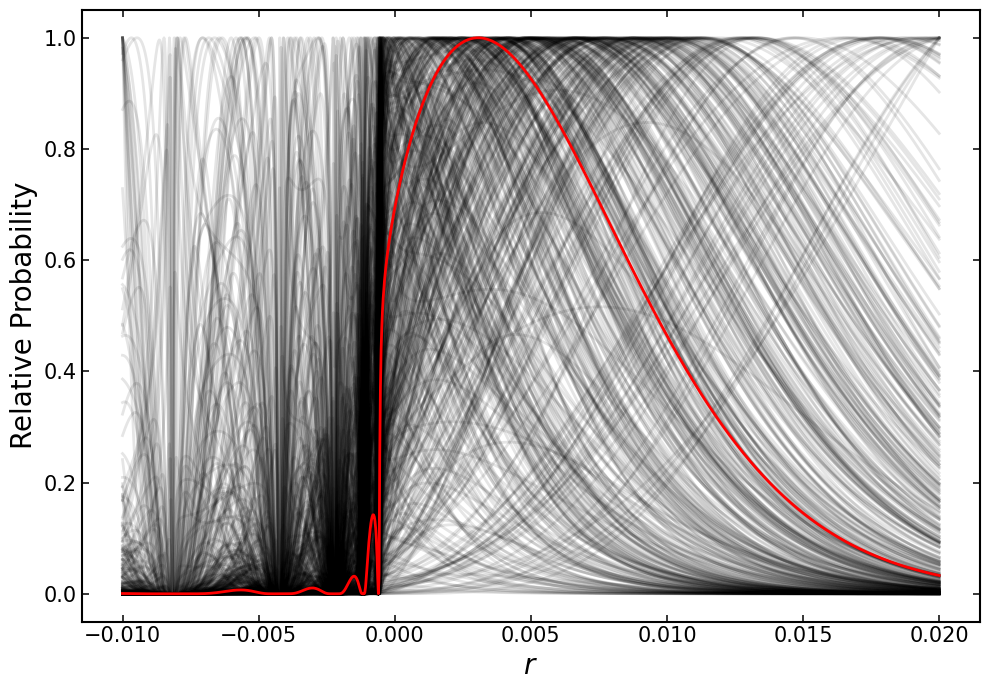

In [24]:
plt.figure()
for i in range(N_sims // 2):
    plt.plot(r005s, np.exp(-0.5*lollipop_no_offset[:, i])/np.max(np.exp(-0.5*lollipop_no_offset[:, i])), color= "black", alpha = 0.1)

plt.plot(r005s, np.exp(-0.5*np.mean(lollipop_no_offset, axis=1))/np.max(np.exp(-0.5*np.mean(lollipop_no_offset, axis=1))))

plt.xlabel(r"$r$")
plt.ylabel("Relative Probability")
plt.show()

<h2 style="text-align: center;">LoLLiPoP-like</h2>

\begin{gather*}

\chi^2 = \Big[(C^{Fid}_\ell + O_\ell) g\Big( \frac{\hat{C}_\ell + O_\ell}{C^{th}_\ell + O_\ell} \Big)\Big] \times (\text{COV}^{-1}_{\ell \ell^\prime})_{Fid.} \times \Big[(C^{Fid}_\ell + O_\ell) g\Big( \frac{\hat{C}_\ell + O_\ell}{C^{th}_\ell + O_\ell} \Big)\Big]  \qquad \\

\text{where} \qquad \\ 
C^{th}_\ell = C_\ell^{Prim.} + C_\ell^{Lens.} + N_\ell \qquad \\
C^{Fid}_\ell = C_\ell^{Lens.} + N_\ell \qquad \\
g(x) = \text{sign}(x)\text{sign}(|x| - 1)\sqrt{2(|x|-\log |x| -1)} \qquad

\end{gather*}

In [25]:
for r_idx in tqdm(range(len(r005s)), desc="LoLLiPoP".center(30)):
    lollipop[r_idx] = get_lollipop_chi2(
                data=cutsky_spectra[int(N_sims / 2):, 1],
                template=templates[r_idx],
                fiducial=fiducial_spectrum[2:, 2],
                noise=noise_spectrum + systematic_spectrum if mitigate_systematic else noise_spectrum,
                offset=offset,
                inv_cov=inv_covariance,
            )
file = f"{prefix}lollipop_{fsky}fsky_80arcminbeam_1000sims.npy"
np.save(chi2s_folder + file, lollipop)

print("LoLLiPoP done")
print(lollipop.shape)

           LoLLiPoP           : 100%|██████████████████████████████████████████████| 1201/1201 [00:02<00:00, 493.75it/s]

LoLLiPoP done
(1201, 500)


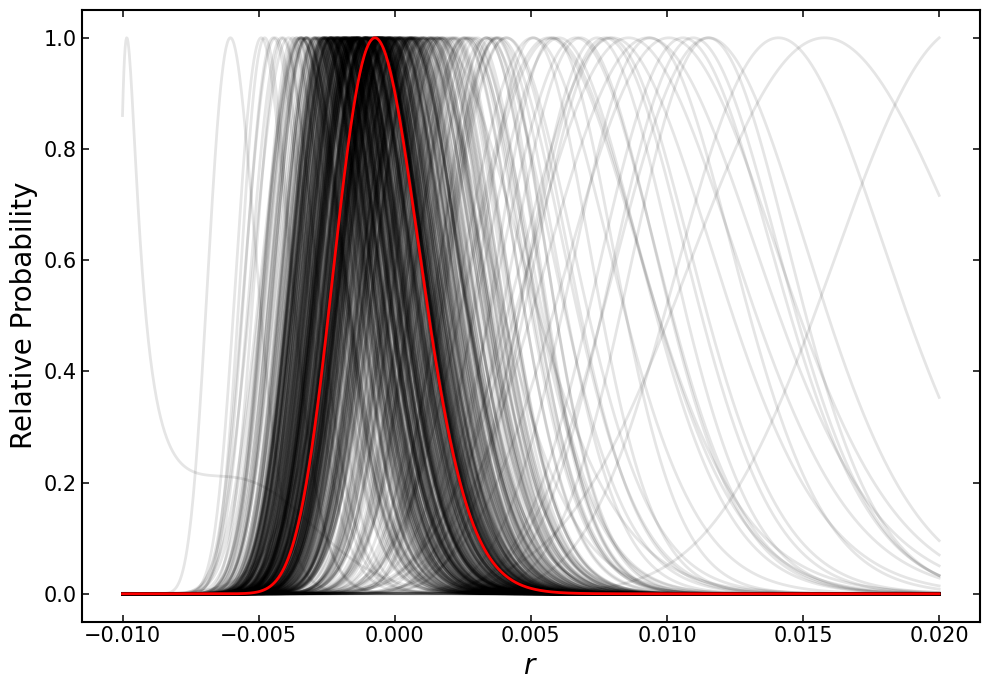

In [26]:
plt.figure()
for i in range(N_sims // 2):
    plt.plot(r005s, np.exp(-0.5*lollipop[:, i])/np.max(np.exp(-0.5*lollipop[:, i])), color= "black", alpha = 0.1)

plt.plot(r005s, np.exp(-0.5*np.mean(lollipop, axis=1))/np.max(np.exp(-0.5*np.mean(lollipop, axis=1))))

plt.xlabel(r"$r$")
plt.ylabel("Relative Probability")
plt.show()